In [1]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc
)

In [2]:
# --- Step 2: Load Dataset ---
df = pd.read_csv("C:/Users/DELL/Desktop/MSc/1st Sem/AML/Loan_Default - Copy.csv")

In [3]:
# Drop identifier if exists
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

In [4]:
# --- Step 3: Data Exploration ---
print(df.head())
print(df.info())

   year loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0  2019         cf  Sex Not Available         nopre     type1           p1   
1  2019         cf               Male         nopre     type2           p1   
2  2019         cf               Male           pre     type1           p1   
3  2019         cf               Male         nopre     type1           p4   
4  2019         cf              Joint           pre     type1           p1   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  ...  \
0                l1        nopc                  nob/c       116500  ...   
1                l1        nopc                    b/c       206500  ...   
2                l1        nopc                  nob/c       406500  ...   
3                l1        nopc                  nob/c       456500  ...   
4                l1        nopc                  nob/c       696500  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0        

In [5]:
# Missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 loan_limit                    1109
approv_in_adv                  277
loan_purpose                    38
rate_of_interest             12209
Interest_rate_spread         12281
Upfront_charges              13287
term                            16
Neg_ammortization               40
property_value                5104
income                        3008
age                             72
submission_of_application       72
LTV                           5104
dtir1                         8072
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_11512\3176283813.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Status", data=df, palette="coolwarm")


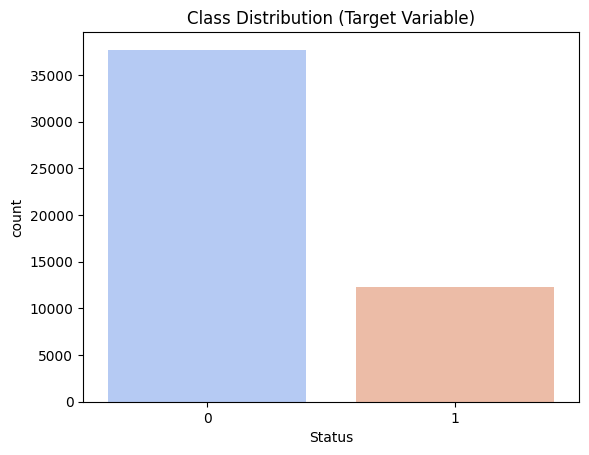

In [6]:
# Target distribution
sns.countplot(x="Status", data=df, palette="coolwarm")
plt.title("Class Distribution (Target Variable)")
plt.show()

In [7]:
# --- Step 4: Pre-Processing ---
# Separate numeric & categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Impute numeric with median
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical with mode
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# One-hot encode categoricals
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_array = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols), index=df.index)

In [9]:
# Define X and y
X = pd.concat([df[num_cols].drop("Status", axis=1, errors="ignore"), encoded_df], axis=1)
y = df["Status"]

In [10]:
# --- Step 5: Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", pd.Series(y_train_res).value_counts())

After SMOTE: Status
0.0    30174
1.0    30174
Name: count, dtype: int64


In [13]:
# --- Step 6a: Baseline SVM ---
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train_res, y_train_res)
y_pred = svm.predict(X_test_scaled)

print("Baseline SVM Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline SVM Results:
[[7082  462]
 [ 136 2320]]
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      7544
         1.0       0.83      0.94      0.89      2456

    accuracy                           0.94     10000
   macro avg       0.91      0.94      0.92     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
# --- Step 6b: Hyperparameter Tuning ---
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf", "linear"]
}

grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=2
)
grid_svm.fit(X_train_res, y_train_res)

print("Best Parameters:", grid_svm.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
# Final model
best_svm = grid_svm.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)

print("Tuned SVM Results:")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

In [ ]:
# --- Step 7: ROC Curve ---
y_proba = best_svm.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.show()